### Import dependencies

In [2]:
import numpy as np
import scipy as sp
import netCDF4 as nC4
import lmoments3 as lm3
# import lmoments3.distr
# import lmoments3.stats
import scipy.signal
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
import eofs
from cdo import Cdo
cdo = Cdo(tempdir='/network/aopp/chaos/pred/leach/.cdo_temp_files1')
# uncomment the below if you want to clean up the temporary directory
cdo.cleanTempDir()
import cartopy
from cartopy import crs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature
import xarray as xr
import xskillscore as xs
import os
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import sys
import glob
import datetime
import time
import multiprocessing
import tqdm
import cmocean
from shapely.geometry.polygon import LinearRing

import pyarrow as pa
import pyarrow.parquet as pq

sys.path.append('/home/leach/Downloads/')
import ScientificColourMaps6 as SCM6

from IPython.display import display, clear_output

# import my own statistics repository
from mystatsfunctions import LMoments,OLSE

## Matplotlib rcparams setup:
matplotlib.rcParams['font.family']='Helvetica'
matplotlib.rcParams['font.size']=11
# matplotlib.rcParams['font.weight']=400
matplotlib.rcParams['image.cmap']='cmo.ice'
matplotlib.rcParams['axes.prop_cycle']=matplotlib.cycler('color',['011936','FF7D00','225560','BFACAA','D72638','788C9B','A33F00','7CAAB0','685655','EB767C'])
matplotlib.rcParams['axes.formatter.limits']=-3,3
# matplotlib.rcParams['axes.labelweight']=300
matplotlib.rcParams['legend.frameon']=False
matplotlib.rcParams['boxplot.whiskers']=(5,95)
matplotlib.rcParams['boxplot.showfliers']=False
matplotlib.rcParams['boxplot.showfliers']=False
matplotlib.rcParams['boxplot.medianprops.color']='black'
matplotlib.rcParams['errorbar.capsize']=5
matplotlib.rcParams['hist.bins']='auto'
plt.rcParams['pdf.fonttype'] = 42

%matplotlib inline

In [3]:
## plotting functions:

def add_lat_lon_ticks(ax,lat=True,lon=True, lon_ext=[-180,181], lat_ext=[-90,91]):
    if lon:
        ax.set_xticks(np.arange(*lon_ext,30), crs=crs.PlateCarree())
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        ax.xaxis.set_major_formatter(lon_formatter)
    if lat:
        ax.set_yticks(np.arange(*lat_ext,10), crs=crs.PlateCarree())
        lat_formatter = LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)

## Import Data

#### Useful definitions
Defines the PRUDENCE region extents and imports the a land-sea mask.

In [4]:
## define EU domain:
EU_rg = "-27,45,33,73.5"

## define PRUDENCE region extents:
PD_rg = dict(zip(['BI','IP','FR','CE','SC','AL','MD','EE'],['-10,2,50,59','-10,3,36,44','-5,5,44,50','2,16,48,55','5,30,55,70','5,15,44,48','3,25,36,44','16,30,44,55']))
print(PD_rg)

## get land-sea mask & inversion:
lsm = cdo.setctomiss('0',input= '-gtc,0.5 ../../ERA5/ERA5_land_sea_mask.nc')
lsm_inv = cdo.setctomiss('0',input= '-ltc,0.5 ../../ERA5/ERA5_land_sea_mask.nc')

{'BI': '-10,2,50,59', 'IP': '-10,3,36,44', 'FR': '-5,5,44,50', 'CE': '2,16,48,55', 'SC': '5,30,55,70', 'AL': '5,15,44,48', 'MD': '3,25,36,44', 'EE': '16,30,44,55'}


In [5]:
experiment_index = pd.DataFrame(index=['2019-02-17','2019-02-23'],columns=['PI_co2','INCR_co2'])
experiment_index.loc['2019-02-17'] = ['b2hi','b2hk']
experiment_index.loc['2019-02-23'] = ['b2ht','b2hu']
experiment_index.loc['2019-02-11'] = ['b2i2','b2i3']
experiment_index.loc['2019-02-04'] = ['b2jn','b2jo']

### Global t2m
Retrieve global 2m temperature in operational / reduced CO$_2$ / increased CO$_2$ forecasts.

In [6]:
## global t2m equilibration timescale

ENS_t2m = {}

for fcdate in experiment_index.index:
    print('getting '+fcdate)
#     PI_glob[fcdate] = xr.open_dataset(cdo.merge(input='-selname,t2m ../../IFS_exp/GLOBAL/sfc/pert/'+experiment_index.loc[fcdate,'PI_co2']+'_t2m.nc -setlevel,51 -selname,t2m ../../IFS_exp/GLOBAL/sfc/ctrl/'+experiment_index.loc[fcdate,'PI_co2']+'_t2m.nc'),chunks={'time':10}).t2m
#     INCR_glob[fcdate] = xr.open_dataset(cdo.merge(input='-selname,t2m ../../IFS_exp/GLOBAL/sfc/pert/'+experiment_index.loc[fcdate,'INCR_co2']+'_t2m.nc -setlevel,51 -selname,t2m ../../IFS_exp/GLOBAL/sfc/ctrl/'+experiment_index.loc[fcdate,'INCR_co2']+'_t2m.nc'),chunks={'time':10}).t2m
    
    pf = xr.open_dataset(cdo.daymean(input='../../IFS_exp/GLOBAL/sfc/pert/'+experiment_index.loc[fcdate,'PI_co2']+'_t2m.nc'),chunks={'time':1,'number':10})
    cf = xr.open_dataset(cdo.daymean(input='../../IFS_exp/GLOBAL/sfc/ctrl/'+experiment_index.loc[fcdate,'PI_co2']+'_t2m.nc'),chunks={'time':1}).expand_dims({'number':[51]})
    PI = xr.concat([pf,cf],dim='number').assign_coords(longitude=(((pf.longitude + 180) % 360) - 180)).sortby('longitude')
    pf.close()
    cf.close()
    
    pf = xr.open_dataset(cdo.daymean(input='../../IFS_exp/GLOBAL/sfc/pert/'+experiment_index.loc[fcdate,'INCR_co2']+'_t2m.nc'),chunks={'time':1,'number':10})
    cf = xr.open_dataset(cdo.daymean(input='../../IFS_exp/GLOBAL/sfc/ctrl/'+experiment_index.loc[fcdate,'INCR_co2']+'_t2m.nc'),chunks={'time':1}).expand_dims({'number':[51]})
    INC = xr.concat([pf,cf],dim='number').assign_coords(longitude=(((pf.longitude + 180) % 360) - 180)).sortby('longitude')
    pf.close()
    cf.close()
    
    ENS_t2m[fcdate] = xr.concat([PI.expand_dims({'experiment':['pi-CO2']}),INC.expand_dims({'experiment':['incr-CO2']})],dim='experiment').expand_dims({'inidate':[fcdate]}).t2m

getting 2019-02-17


/network/aopp/chaos/pred/leach/software/miniconda3/lib/python3.7/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/network/aopp/chaos/pred/leach/software/miniconda3/lib/python3.7/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[in

getting 2019-02-23


/network/aopp/chaos/pred/leach/software/miniconda3/lib/python3.7/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/network/aopp/chaos/pred/leach/software/miniconda3/lib/python3.7/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[in

getting 2019-02-11


/network/aopp/chaos/pred/leach/software/miniconda3/lib/python3.7/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/network/aopp/chaos/pred/leach/software/miniconda3/lib/python3.7/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[in

getting 2019-02-04


/network/aopp/chaos/pred/leach/software/miniconda3/lib/python3.7/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/network/aopp/chaos/pred/leach/software/miniconda3/lib/python3.7/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[in

Get land-sea masks into xarray.

In [7]:
lm_xr = ~np.isnan(xr.open_dataset(lsm).lsm)
om_xr = np.isnan(xr.open_dataset(lsm).lsm)

lm_xr = lm_xr.assign_coords(longitude=(((lm_xr.longitude + 180) % 360) - 180)).sortby('longitude')
om_xr = om_xr.assign_coords(longitude=(((om_xr.longitude + 180) % 360) - 180)).sortby('longitude')

lat_weights = np.cos(np.deg2rad(lm_xr.latitude))

Subtract the increased CO$_2$ forecast from the reduced forecast and divide by 2 to get the signal.

In [8]:
land_co2sig = []
ocean_co2sig = []

for fcdate in experiment_index.index:
    print('computing '+fcdate)
    land_co2sig += [((ENS_t2m[fcdate].sel(experiment='incr-CO2') - ENS_t2m[fcdate].sel(experiment='pi-CO2')).where(lm_xr).weighted(lat_weights).mean(['latitude','longitude'])/2).stack(index=['inidate','number']).to_pandas()]
    ocean_co2sig += [((ENS_t2m[fcdate].sel(experiment='incr-CO2') - ENS_t2m[fcdate].sel(experiment='pi-CO2')).where(om_xr).weighted(lat_weights).mean(['latitude','longitude'])/2).stack(index=['inidate','number']).to_pandas()]
    
land_co2sig = pd.concat(land_co2sig,axis=1)
ocean_co2sig = pd.concat(ocean_co2sig,axis=1)

## need to add in zero points

computing 2019-02-17
computing 2019-02-23
computing 2019-02-11
computing 2019-02-04


Wrangle resulting dataframes into nice format for plotting.

In [9]:
global_t2m_lineplot_data = pd.concat([land_co2sig,ocean_co2sig],axis=1,keys=['land','ocean'])

global_t2m_lineplot_data.loc[pd.to_datetime('2019-02-03 10:00:00')] = np.nan
global_t2m_lineplot_data.loc[pd.to_datetime('2019-02-03 10:00:00'),(slice(None),'2019-02-04')] = 0
global_t2m_lineplot_data.loc[pd.to_datetime('2019-02-10 10:00:00'),(slice(None),'2019-02-11')] = 0
global_t2m_lineplot_data.loc[pd.to_datetime('2019-02-16 10:00:00'),(slice(None),'2019-02-17')] = 0
global_t2m_lineplot_data.loc[pd.to_datetime('2019-02-22 10:00:00'),(slice(None),'2019-02-23')] = 0

global_t2m_lineplot_data.index = global_t2m_lineplot_data.index + pd.Timedelta('+14h')

global_t2m_boxplot_data = global_t2m_lineplot_data.sort_index().loc[slice('2019-02-25','2019-02-27')].mean()

Print out some key values for the text.

In [80]:
## global mean land temperature changes for 2019-02-11 forecast

print('best-estimate change in mean land temperature changes (median, 5%, 95%):\n',*np.quantile(np.median(np.random.choice(global_t2m_boxplot_data.land.loc['2019-02-11'].values,51*10000).reshape(51,-1),axis=0),[0.5,0.05,0.95]))

best-estimate change in mean land temperature changes (median, 5%, 95%):
 0.2231527715921402 0.19632500410079956 0.2498052567243576


In [69]:
## symmetry of global temperature response to co2

land_incrco2_resp = ENS_t2m['2019-02-11'].sel(experiment='incr-CO2',time=slice('2019-02-25','2019-02-27')).where(lm_xr).weighted(lat_weights).mean(['latitude','longitude','time']).values
land_redco2_resp = ENS_t2m['2019-02-11'].sel(experiment='pi-CO2',time=slice('2019-02-25','2019-02-27')).where(lm_xr).weighted(lat_weights).mean(['latitude','longitude','time']).values

## get operational value:
pf = xr.open_dataset(cdo.daymean(input='../../OPERATIONAL/GLOBAL/sfc/pert/2019-02-11_t2m.nc'),chunks={'time':1,'number':10})
cf = xr.open_dataset(cdo.daymean(input='../../OPERATIONAL/GLOBAL/sfc/ctrl/2019-02-11_t2m.nc'),chunks={'time':1}).expand_dims({'number':[51]})
OP = xr.concat([pf,cf],dim='number').assign_coords(longitude=(((pf.longitude + 180) % 360) - 180)).sortby('longitude')
pf.close()
cf.close()

land_base_resp = OP.t2m.sel(time=slice('2019-02-25','2019-02-27')).mean('time').where(lm_xr).weighted(lat_weights).mean(['latitude','longitude']).values

/network/aopp/chaos/pred/leach/software/miniconda3/lib/python3.7/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [79]:
print('Increased CO2 response (median, 5%, 95%):')
print(*np.quantile(np.median(np.random.choice((land_incrco2_resp-land_base_resp).flatten(),51*10000).reshape(51,-1),axis=0),[0.5,0.05,0.95]),'\n')
print('Reduced CO2 response (median, 5%, 95%):')
print(*np.quantile(np.median(np.random.choice((land_redco2_resp-land_base_resp).flatten(),51*10000).reshape(51,-1),axis=0),[0.5,0.05,0.95]))

Increased CO2 response (median, 5%, 95%):
0.227569580078125 0.216552734375 0.337493896484375 

Reduced CO2 response (median, 5%, 95%):
-0.171295166015625 -0.289764404296875 -0.113861083984375


### Large-scale flow over Europe

Retrieve Z500 in operational / reduced CO$_2$ / increased CO$_2$ forecasts.

In [10]:
## Z500 divergence from ensemble mean / ensemble member

ENS_z500_eu = {}

for fcdate in experiment_index.index:
    print('getting '+fcdate)
#     PI_glob[fcdate] = xr.open_dataset(cdo.merge(input='-selname,t2m ../../IFS_exp/GLOBAL/sfc/pert/'+experiment_index.loc[fcdate,'PI_co2']+'_t2m.nc -setlevel,51 -selname,t2m ../../IFS_exp/GLOBAL/sfc/ctrl/'+experiment_index.loc[fcdate,'PI_co2']+'_t2m.nc'),chunks={'time':10}).t2m
#     INCR_glob[fcdate] = xr.open_dataset(cdo.merge(input='-selname,t2m ../../IFS_exp/GLOBAL/sfc/pert/'+experiment_index.loc[fcdate,'INCR_co2']+'_t2m.nc -setlevel,51 -selname,t2m ../../IFS_exp/GLOBAL/sfc/ctrl/'+experiment_index.loc[fcdate,'INCR_co2']+'_t2m.nc'),chunks={'time':10}).t2m
    
    pf = xr.open_dataset('../../IFS_exp/Feb_2019/plev/'+experiment_index.loc[fcdate,'PI_co2']+'_plev_500_pf.nc',chunks={'time':1,'number':10}).z
    cf = xr.open_dataset('../../IFS_exp/Feb_2019/plev/'+experiment_index.loc[fcdate,'PI_co2']+'_plev_500_cf.nc',chunks={'time':1}).expand_dims({'number':[51]}).z
    PI = xr.concat([pf,cf],dim='number').assign_coords(longitude=(((pf.longitude + 180) % 360) - 180)).sortby('longitude').sel(time=slice(fcdate,'2019-02-27'))
    pf.close()
    cf.close()
    
    pf = xr.open_dataset('../../IFS_exp/Feb_2019/plev/'+experiment_index.loc[fcdate,'INCR_co2']+'_plev_500_pf.nc',chunks={'time':1,'number':10}).z
    cf = xr.open_dataset('../../IFS_exp/Feb_2019/plev/'+experiment_index.loc[fcdate,'INCR_co2']+'_plev_500_cf.nc',chunks={'time':1}).expand_dims({'number':[51]}).z
    INC = xr.concat([pf,cf],dim='number').assign_coords(longitude=(((pf.longitude + 180) % 360) - 180)).sortby('longitude').sel(time=slice(fcdate,'2019-02-27'))
    pf.close()
    cf.close()
    
    pf = xr.open_dataset('../../OPERATIONAL/EU_FEB_19/plev/'+fcdate+'.nc',chunks={'time':1,'number':10}).Z500
    cf = xr.open_dataset('../../OPERATIONAL/EU_FEB_19/plev/ctrl/'+fcdate+'.nc',chunks={'time':1}).expand_dims({'number':[51]}).Z500
    OP = xr.concat([pf,cf],dim='number').assign_coords(longitude=(((pf.longitude + 180) % 360) - 180)).sortby('longitude').sel(time=slice(fcdate,'2019-02-27'))
    pf.close()
    cf.close()
    
    ENS_z500_eu[fcdate] = xr.concat([PI.expand_dims({'experiment':['pi-CO2']}),INC.expand_dims({'experiment':['incr-CO2']}),OP.expand_dims({'experiment':['operational']})],dim='experiment').expand_dims({'inidate':[fcdate]})

getting 2019-02-17
getting 2019-02-23
getting 2019-02-11
getting 2019-02-04


Create weights array.

In [11]:
EU_lat_weights = np.cos(np.deg2rad(ENS_z500_eu[fcdate].latitude))

#### Get mean absolute Z500 distance between ensemble members.
ie. intra-ensemble distances

In [12]:
OPERATIONAL_Z500_distance = []

for fcdate in experiment_index.index:
    # calculate mean absolute distance between ensemble members over EU domain for each inidate
    OPERATIONAL_Z500_distance += [
        xr.concat(
            [np.fabs(
                (ENS_z500_eu[fcdate].sel(number=ensmem,experiment='operational').dropna(dim='time')-ENS_z500_eu[fcdate].isel(number=ENS_z500_eu[fcdate].number!=ensmem).sel(experiment='operational').dropna(dim='time'))
            ).weighted(EU_lat_weights).mean(['latitude','longitude']).rename(number='number1').assign_coords(number1=np.arange(50)) for ensmem in ENS_z500_eu[fcdate].number],dim='number'
        )
    ]
    
OPERATIONAL_Z500_distance = xr.concat(OPERATIONAL_Z500_distance,dim='inidate').compute()

/network/aopp/chaos/pred/leach/software/miniconda3/lib/python3.7/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/network/aopp/chaos/pred/leach/software/miniconda3/lib/python3.7/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[in

#### Get mean absolute Z500 distance between experiments members.

ie. inter-experimental distances

In [13]:
import itertools

EXPERIMENTAL_Z500_distance = []

for fcdate in experiment_index.index:
    fcdate_EXP_Z500_dist = []
    for exp1,exp2 in itertools.combinations(ENS_z500_eu[fcdate].experiment.values,2):
        fcdate_EXP_Z500_dist += [np.fabs(ENS_z500_eu[fcdate].sel(experiment=exp1) - ENS_z500_eu[fcdate].sel(experiment=exp2)).weighted(EU_lat_weights).mean(['latitude','longitude']).expand_dims({'experiment':[exp1+'|'+exp2]})]
        
    EXPERIMENTAL_Z500_distance += [xr.concat(fcdate_EXP_Z500_dist,dim='experiment')]
    
EXPERIMENTAL_Z500_distance = xr.concat(EXPERIMENTAL_Z500_distance,dim='inidate').compute()

Wrangle into nice format for plotting.

In [15]:
### distances between experiments / operational ensemble members
operational_divegence_plot_data = (OPERATIONAL_Z500_distance/9.80665).stack(index=['inidate','time','number','number1']).to_pandas().sort_index().reset_index().rename({0:'distance'},axis=1).dropna()
experimental_divegence_plot_data = (EXPERIMENTAL_Z500_distance/9.80665).stack(index=['inidate','experiment','time','number']).to_pandas().sort_index().reset_index().rename({0:'distance'},axis=1).dropna()

Finally, get mean absolute error (distance) from ERA5.

In [29]:
### MAD from ERA5
ERA5_EU_Z500 = xr.open_dataset('../../ERA5/EU_FEB_19/ERA5_plev_500-850_2019.nc').z.sel(level=500,time=slice('2019-02-04','2019-02-27'))

EU_z500_error = []
for fcdate in experiment_index.index:
    EU_z500_error+=[np.fabs(ENS_z500_eu[fcdate]-ERA5_EU_Z500).weighted(EU_lat_weights).mean(['latitude','longitude'])]
    
EU_z500_error = (xr.concat(EU_z500_error,dim='inidate')/9.80665).stack(index=['inidate','experiment','time','number']).to_pandas().sort_index().reset_index().rename({0:'distance'},axis=1).dropna()

## Create the figure

- panel Aa,Ab : timeseries & boxplot of global mean land / ocean temps
- panel B : MAE from ERA5 of EU Z500
- panel C,D : intra-ensemble / inter-experimental Z500 MAD

In [17]:
## this cell contains definitions for creating the various sigure styles here.

def custom_boxplot(x,y,ax,width=0.2,n_boot=1000,**kwargs):
    # vertically oriented boxplot
    
    ## compute median & confidence:
    box_med = np.median(y)
    box_med_boot = y[np.random.choice(y.size,y.size*n_boot)].reshape(y.size,-1)
    box_med_ci = np.quantile(np.median(box_med_boot,axis=0),[0.05,0.95])
    
    ## compute ensemble spread
    box_ens_ci = np.quantile(y,[0.05,0.95])
    
    ax.fill_between([x,x+width],*box_med_ci,lw=0,**kwargs)
    if 'alpha' in kwargs.keys():
        kwargs['alpha'] = kwargs['alpha']/2
    else:
        kwargs['alpha'] = 0.5
    ax.fill_between([x,x+width],*box_ens_ci,lw=0,**kwargs)
    ax.hlines(box_med,x,x+width,lw=1,color='k')
    
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

def ensemble_mean_percentile(n):
    def percentile_(x):
        return np.percentile(x.values[np.random.choice(x.size,x.size*10000)].reshape(x.size,-1).mean(axis=0), n)
    percentile_.__name__ = 'confidence_%s' % n
    return percentile_

def zonmean_plot(x,y,**kwargs):
    grouped = y.rename(x).groupby(level=0)
    agg = grouped.agg(['mean',percentile(95),percentile(5),ensemble_mean_percentile(95),ensemble_mean_percentile(5)])
    plt.plot(agg.index,agg['mean'],label='mean',**kwargs)
    plt.fill_between(agg.index,agg.percentile_5,agg.percentile_95,alpha=0.2,lw=0,label='ensemble 90 %',**kwargs)
    plt.fill_between(agg.index,agg.confidence_5,agg.confidence_95,alpha=0.2,lw=0,label='mean 90 %',**kwargs)
    
def ensemble_spread_plot(x,y,**kwargs):
    grouped = y.dropna().rename(x).groupby(level=0)
    agg = grouped.agg(['mean',percentile(95),percentile(5)])
    plt.fill_between(agg.index,agg.percentile_5,agg.percentile_95,alpha=0.2,lw=0,**kwargs)

##  Create the figure subplots

For this one, create the subplots individually to be merged in inkscape.

/network/aopp/chaos/pred/leach/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: PerformanceWarning: indexing past lexsort depth may impact performance.


''

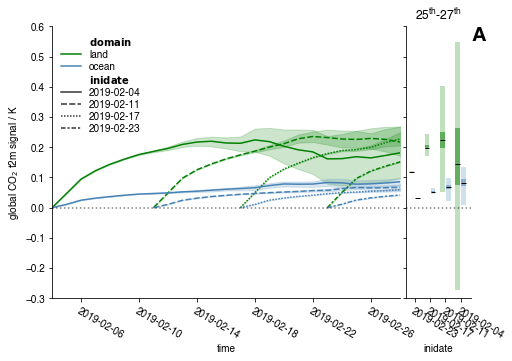

In [18]:
fig = plt.figure(figsize=(7.5,5))
gs = fig.add_gridspec(1,6,wspace=0.1,hspace=0.15)

## PANEL A (+b)

ax = [fig.add_subplot(gs[0,:-1])]

sn.lineplot(data=global_t2m_lineplot_data.unstack().sort_index().reset_index().rename({0:'t2m','level_0':'domain'},axis=1),palette=['g','steelblue'],style='inidate',hue='domain',x='time',y='t2m')
plt.xlim('2019-02-04 00:00:00','2019-02-28 00:00:00')
plt.xticks(global_t2m_lineplot_data.sort_index().index[2::4],labels=[x.strftime("%Y-%m-%d") for x in  pd.to_datetime(global_t2m_lineplot_data.sort_index().index)[2::4]],rotation=-30,ha='left',rotation_mode="anchor")
sn.despine()
plt.ylabel('global CO$_2$ t2m signal / K')

handles = ax[0].get_legend_handles_labels()[0]
labels = ax[0].get_legend_handles_labels()[1]
labels[0] = r'$\bf{'+labels[0]+'}$'
labels[3] = r'$\bf{'+labels[3]+'}$'

plt.legend(handles=handles,labels=labels,labelspacing=0.2,loc=2)

ax += [fig.add_subplot(gs[0,5])]

box_sep = 1
subbox_sep = 0.4

for i,inidate in enumerate(global_t2m_boxplot_data.index.levels[1][::-1]):
    for ii,domain in enumerate(global_t2m_boxplot_data.index.levels[0]):
        custom_boxplot(i*box_sep+ii*subbox_sep,global_t2m_boxplot_data.loc[(domain,inidate)].values,ax=ax[1],n_boot=10000,width=0.3,color=['g','steelblue'][ii],alpha=0.5)
        
ax[1].set_yticklabels([])
plt.xlim(-0.2,4)
plt.xlabel('inidate')
sn.despine()
plt.xticks(np.arange(4)+0.35,global_t2m_boxplot_data.index.levels[1][::-1],rotation=-30,ha='left',rotation_mode="anchor")
plt.title('25$^{\mathregular{th}}$-27$^{\mathregular{th}}$')
ax[1].text(1.02,1,'A',transform=ax[1].transAxes,fontweight='bold',fontsize=20,va='top',ha='left')

[a.set_ylim(-0.3,0.6) for a in ax]
[a.axhline(0,ls=':',color='k',alpha=0.5) for a in ax]

# [fig.savefig('FIGS/Fig3/A.'+x,dpi=600,bbox_inches='tight') for x in ['png','pdf']]
# fig.dpi=300
''

''

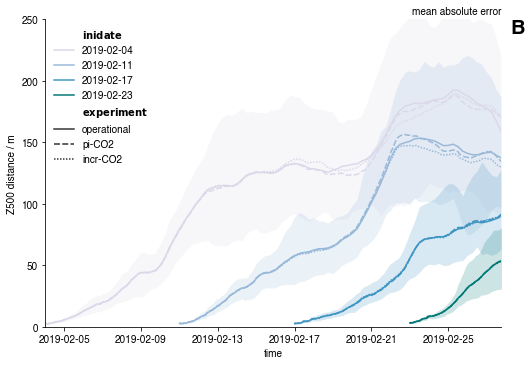

In [31]:
g=sn.FacetGrid(data=EU_z500_error.query('experiment=="operational"'),hue='inidate',palette='PuBuGn',height=5,aspect=7.5/5)
g.map(ensemble_spread_plot,'time','distance')
sn.lineplot(data=EU_z500_error.sort_values(['experiment','inidate'], key=lambda x: x.map({'operational':0,'pi-CO2':1,'incr-CO2':2})),x='time',y='distance',hue='inidate',style='experiment',ci=None,palette='PuBuGn',ax=g.axes[0,0])

handles = g.axes[0,0].get_legend_handles_labels()[0]
labels = g.axes[0,0].get_legend_handles_labels()[1]
labels[0] = r'$\bf{'+labels[0]+'}$'
labels[5] = r'$\bf{'+labels[5]+'}$'

plt.legend(handles=handles[:-4],labels=labels[:-4])

plt.ylabel('Z500 distance / m')
plt.xlim('2019-02-04 00:00:00','2019-02-27 18:00:00')
plt.ylim(0,250)
# plt.gca().set_xticklabels([])
# plt.xlabel('')

g.axes[0,0].text(1.02,1,'B',transform=g.axes[0,0].transAxes,fontweight='bold',fontsize=20,va='top',ha='left')
g.axes[0,0].text(1,1.01,'mean absolute error',transform=g.axes[0,0].transAxes,va='bottom',ha='right')
# plt.title('Experimental error growth',fontweight='bold')
# [g.fig.savefig('FIGS/Fig3/C.'+x,dpi=600,bbox_inches='tight') for x in ['png','pdf']]
''

''

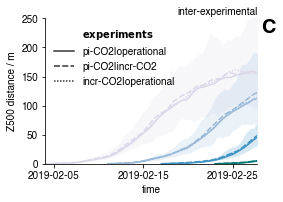

In [21]:
g=sn.FacetGrid(data=experimental_divegence_plot_data.query('experiment=="pi-CO2|incr-CO2"'),hue='inidate',palette='PuBuGn',height=2.75,aspect=7.5/5)
g.map(ensemble_spread_plot,'time','distance')
sn.lineplot(data=experimental_divegence_plot_data.sort_values(['experiment','inidate'], key=lambda x: x.map({'pi-CO2|operational':0,'pi-CO2|incr-CO2':1,'incr-CO2|operational':2})),x='time',y='distance',hue='inidate',style='experiment',ci=None,palette='PuBuGn',ax=g.axes[0,0])

handles = g.axes[0,0].get_legend_handles_labels()[0]
labels = g.axes[0,0].get_legend_handles_labels()[1]
labels[0] = r'$\bf{'+labels[0]+'}$'
labels[5] = r'$\bf{'+labels[5]+'s}$'

plt.legend(handles=handles[5:-4],labels=labels[5:-4],loc=2)

plt.ylabel('Z500 distance / m')
plt.xlim('2019-02-04 00:00:00','2019-02-27 18:00:00')
plt.ylim(0,250)
plt.gca().set_xticks(['2019-02-05','2019-02-15','2019-02-25'])
# plt.xlabel('')

g.axes[0,0].text(1.02,1,'C',transform=g.axes[0,0].transAxes,fontweight='bold',fontsize=20,va='top',ha='left')
g.axes[0,0].text(1,1.01,'inter-experimental',transform=g.axes[0,0].transAxes,va='bottom',ha='right')
# plt.title('inter-experimental error growth',fontweight='bold')

# [g.fig.savefig('FIGS/Fig3/D.'+x,dpi=600,bbox_inches='tight') for x in ['png','pdf']]
''

''

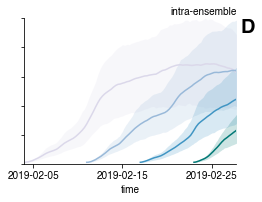

In [22]:
g=sn.FacetGrid(data=operational_divegence_plot_data,hue='inidate',palette='PuBuGn',height=2.75,aspect=7.5/5)
g.map(ensemble_spread_plot,'time','distance')
sn.lineplot(data=operational_divegence_plot_data,x='time',y='distance',hue='inidate',ci=None,palette='PuBuGn',ax=g.axes[0,0])

plt.xlim('2019-02-04 00:00:00','2019-02-27 18:00:00')
plt.ylim(0,250)
plt.gca().set_yticklabels([])
# plt.title('intra-ensemble error growth',fontweight='bold')
plt.ylabel('')
plt.gca().set_xticks(['2019-02-05','2019-02-15','2019-02-25'])

plt.gca().get_legend().remove()

g.axes[0,0].text(1.02,1,'D',transform=g.axes[0,0].transAxes,fontweight='bold',fontsize=20,va='top',ha='left')
g.axes[0,0].text(1,1.01,'intra-ensemble',transform=g.axes[0,0].transAxes,va='bottom',ha='right')

# [g.fig.savefig('FIGS/Fig3/E.'+x,dpi=600,bbox_inches='tight') for x in ['png','pdf']]
''